# Truls de Lange - CA3

## Some circumstance:

I have 4 subjects this semester and am really trying to make a good effort in all of them. A backside to this, is that all subjects
are bound to have overlapping assignments with corresponding deadlines right before easter. Thus, I had one midway exam, two major compulsory assignments and two weekly copulsory assignments to get done just the past two weeks - four of which within the first 4 days of this week. If this weren't the case, I would have put much more effort into this assignment to get a score as good as possible. I couldn't do that this time, which I hope you understand. The methods I used here may also not be that thorough or tidy - I'm sorry, but I couldn't really pay that much attention to it. I just had to beat the Kaggle score and get it done.

### Imports

In [3]:
# Whenever I needed to import a library at any point in the notebook, I entered it here at the top
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

### Reading data

In [4]:
# I read the data in as a pandas dataframe, so that it can be managed with pandas features
data = pd.read_csv("train.csv")
df = pd.DataFrame(data)
df = df.drop(columns='Unnamed: 0')
df.columns

Index(['Acoustic Firmness Index', 'Atmospheric Pressure at Harvest (Pa)',
       'Bitterness Scale', 'Circumference (mm)', 'Color Intensity (a.u.)',
       'Find Distance from Main Vulcano (km)', 'Length (mm)',
       'Luminescence Intensity (a.u.)', 'Magnetic orientation (degree)',
       'Odor index (a.u.)', 'Seed Count', 'Skin Thickness (mm)',
       'Soil pH where Grown', 'Sugar Content (mg)', 'Weight (mg)', 'pH',
       'Edible'],
      dtype='object')

### Data exploration and visualisation

1248


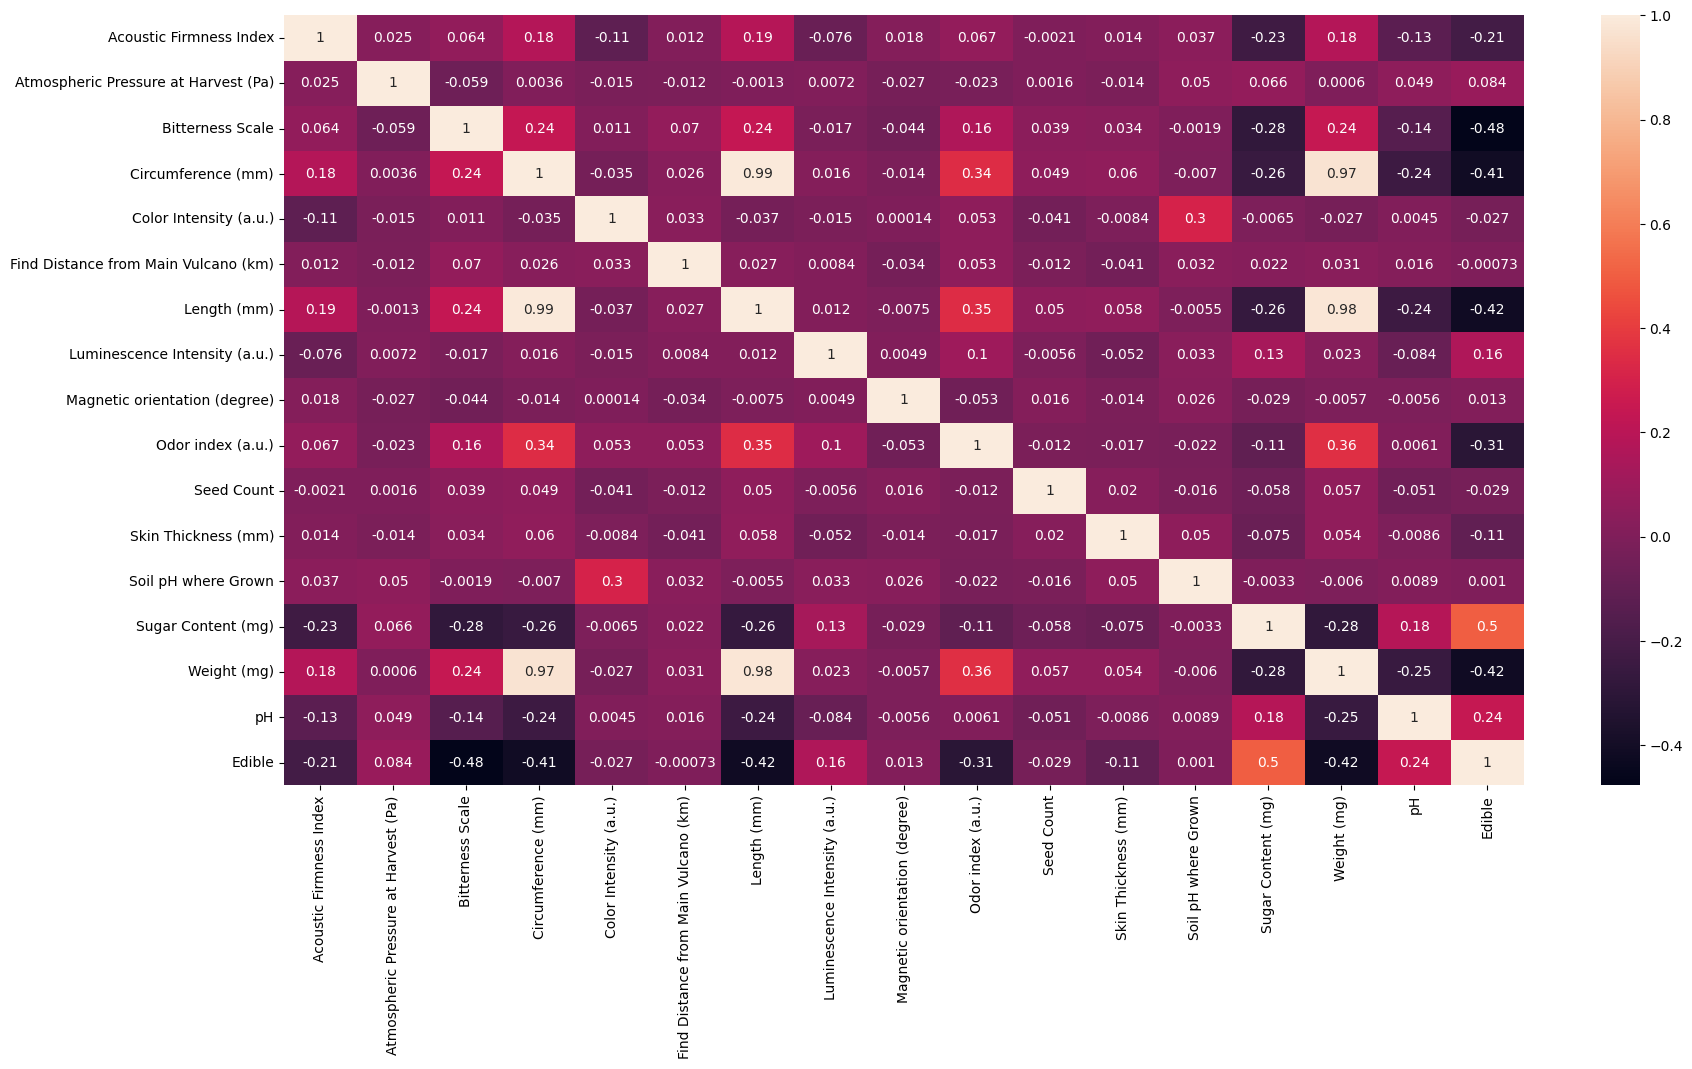

In [5]:
# Plotting a heatmap of the linear correlation coefficient between all features in the dataset, to check for linear correlation
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr(), annot=True)
plt.plot()

print(len(df))

Row 1 complete
Row 2 complete
Row 3 complete
Row 4 complete
Row 5 complete
Row 6 complete
Row 7 complete
Row 8 complete
Row 9 complete
Row 10 complete
Row 11 complete
Row 12 complete
Row 13 complete
Row 14 complete
Row 15 complete
Row 16 complete
Row 17 complete
Row 18 complete
Row 19 complete
Row 20 complete


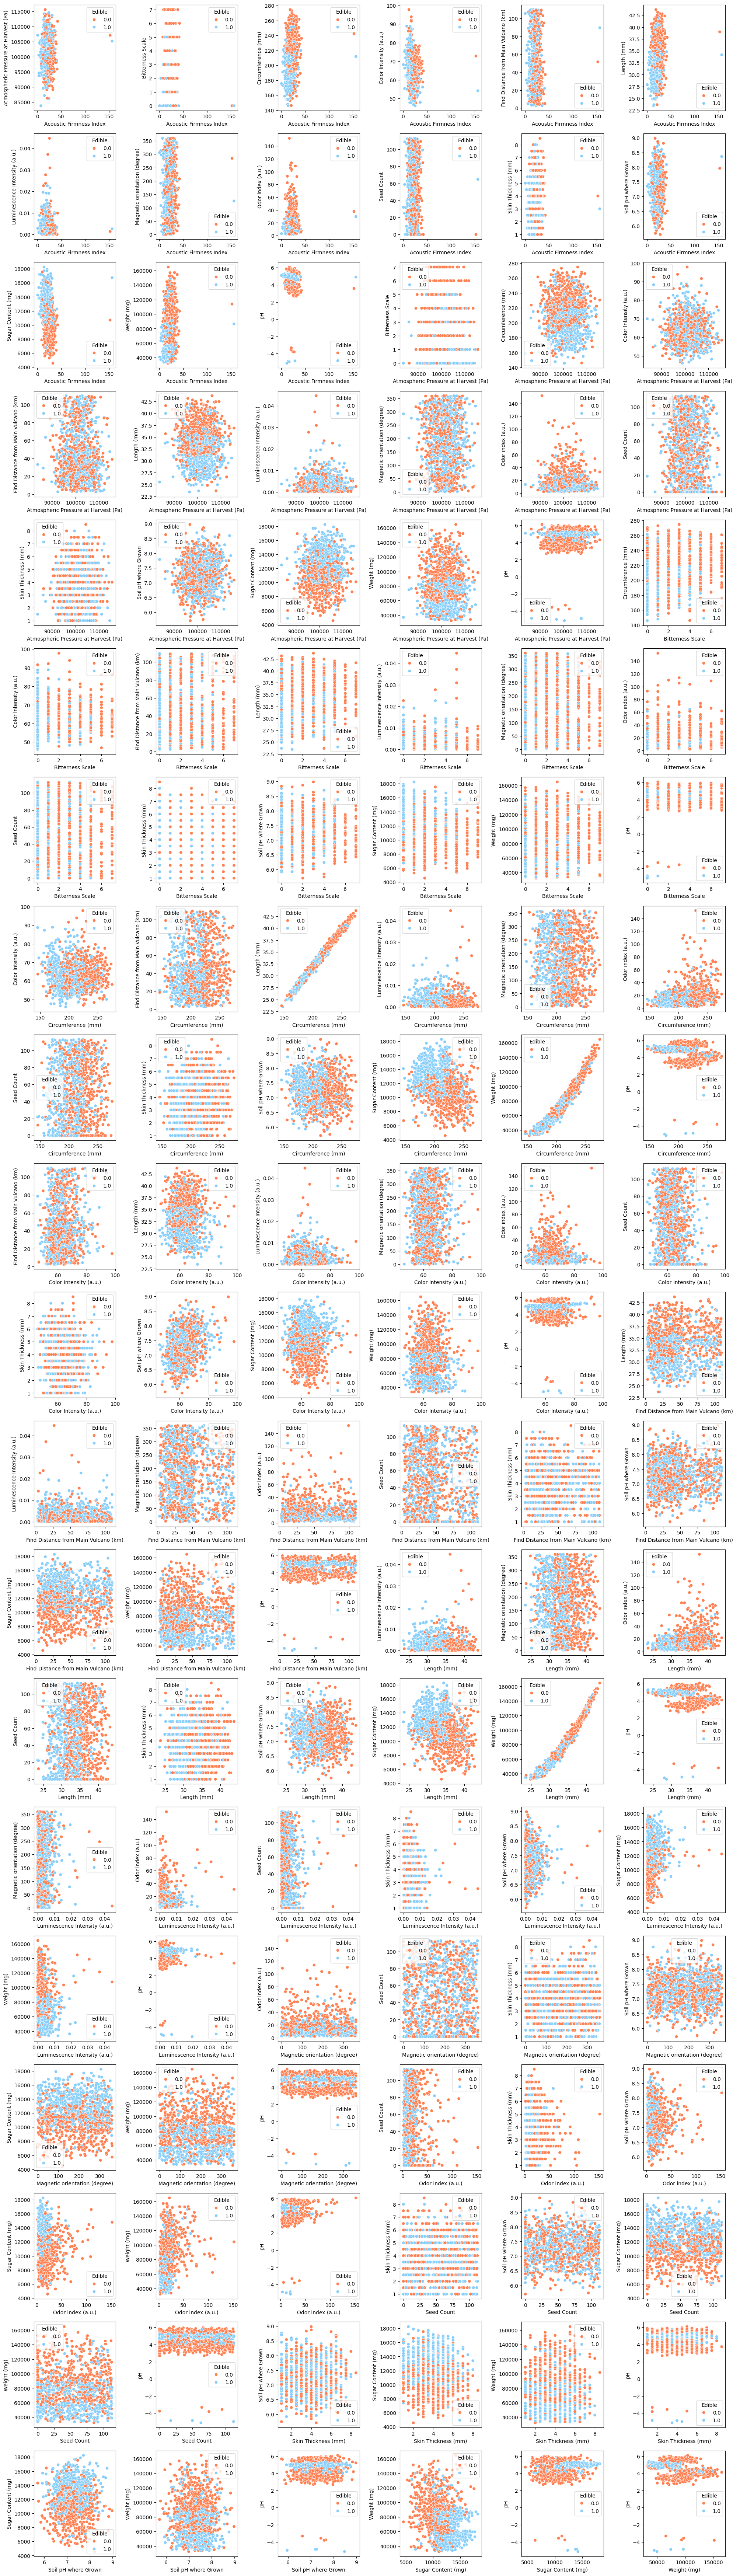

'\n\ncategories = [train_df.]\n'

In [6]:
"""Since there was little linear correlation between any two features, I plot scatter plots of all pairs to check for any other
kind of correlation"""

features = list(df)
target = 'Edible'

features.remove('Edible')
features1 = features.copy()
features2 = features.copy()

fig, ax = plt.subplots(20, 6, figsize=(20, 70))

row = 0
col = 0

for feat1 in features1:  
    for feat2 in features2:
        if feat2 == feat1:
            continue
        sns.scatterplot(x=feat1, y=feat2, hue=target, data=df, palette={0: 'coral', 1: 'lightskyblue'}, ax=ax[row][col])
        if col == 5:
            col = 0
            row += 1
            print(f'Row {row} complete')
        else:
            col += 1
    features2.remove(feat1)

plt.tight_layout()
plt.show()
    
"""

categories = [train_df.]
"""

__Comments on the initial visualisation__:

After pairing features and visualising them in scatter plots with target label `Edible`as hue parameter, it seems as if the pH feture, first and foremost, is going to be of great significance to the classification. This is because almost all the plots with pH as one of the features display more or less clearly separable data points. Secondly come the size features (circumference, length, weight...), which also seem to create tidy plots.

One can also see some outliers, above all in the pH-values. This is something I didn't take into account in my calculations, because I thought it would harm the accuracy of the eventual model to get rid of these. This is a decision I grew uncertain of later on, as they may have made both the standardisation, the swapping of NaN-values with mean-values and the final predictions less accurate. 

### Data cleaning

In [20]:
# Z-score (I more or less copy-pasted this code section from the lecture codes, because I'm not used to this kind of numpy notation:)
z_scores = (df - df.mean()) / df.std()
outliers = np.abs(z_scores) > 3
np.sum(outliers, axis=0)
# A z-score of 3 although matches with what is visible in the scatter plots (8 outliers in pH, 18 in luminescence ...). I stick to the z-score of 3.

Acoustic Firmness Index                  2
Atmospheric Pressure at Harvest (Pa)     3
Bitterness Scale                         0
Circumference (mm)                       0
Color Intensity (a.u.)                  12
Find Distance from Main Vulcano (km)     0
Length (mm)                              0
Luminescence Intensity (a.u.)           18
Magnetic orientation (degree)            0
Odor index (a.u.)                       28
Seed Count                               0
Skin Thickness (mm)                      1
Soil pH where Grown                      2
Sugar Content (mg)                       1
Weight (mg)                              1
pH                                       8
Edible                                   0
dtype: int64

In [30]:
df_clean = df.mask(outliers)

In [38]:
# X / y split:
y = pd.DataFrame(df['Edible'])
X = df.drop(y, axis=1)
y = y['Edible'].tolist()

In [39]:
print(X[X.isnull().any(axis=1)].shape)
X[X.isnull().any(axis=1)]

(37, 16)


Acoustic Firmness Index  Atmospheric Pressure at Harvest (Pa)  \
9                        18.6                               98441.0   
25                       25.3                              102300.0   
135                      24.4                               98459.0   
161                      21.8                               97338.0   
190                      21.0                              109623.0   
203                      31.4                              110062.0   
237                      16.6                              106015.0   
280                      27.3                              101351.0   
330                       6.2                              100398.0   
354                      18.0                               95815.0   
411                      11.8                              103065.0   
422                      23.0                               98213.0   
434                       NaN                              103487.0   
440                       NaN                              100351.0   
450                      25.0                               99958.0   
474                      20.6                               97311.0   
557                      24.7                              103056.0   
568                      13.6                               96623.0   
585                       7.6                               98346.0   
761                      12.7                               97565.0   
788                      17.3                               95421.0   
810                      23.0                              102198.0   
827                      15.8                              109257.0   
859                       NaN                               98582.0   
896                      14.0                               98721.0   
915                      19.9                              102155.0   
970                      31.3                              104463.0   
986                      12.8                              103134.0   
1009                     23.7                              101788.0   
1033                     20.3                               90924.0   
1063                     27.0                              101195.0   
1105                     17.7                              103471.0   
1124                     15.8                              102290.0   
1132                     21.9                              101497.0   
1146                     18.4                               98481.0   
1162                     20.4                              106357.0   
1212                     22.6                              102717.0   

      Bitterness Scale  Circumference (mm)  Color Intensity (a.u.)  \
9                  NaN          193.742185                   56.51   
25                 4.0          190.527909                   60.61   
135                0.0          217.066116                   56.70   
161                2.0          196.793798                   64.13   
190                0.0          217.672365                   58.28   
203                6.0          247.568906                   70.78   
237                4.0          223.744843                   62.78   
280                2.0          245.449299                   62.16   
330                0.0          218.614502                   62.09   
354                0.0          210.940636                   62.55   
411                4.0          226.188200                   81.36   
422                NaN          191.714105                   60.34   
434                4.0          188.322992                   55.76   
440                0.0          162.971214                   60.46   
450                2.0                 NaN                   66.92   
474                0.0          213.961499                   56.04   
557                4.0          248.559479                   73.22   
568                1.0          147.912611     

### Data preprocessing and visualisation

In [40]:
"""As shown above, there are very many rows with NaN-values scattered over many different columns. I thus see removing rows 
and/or columns with NaN-values as inconvenient, considering the fairly small size of the dataset. I chose the mean-strategy instead,
which I thought would be a good substitute - although I see now, that I maybe should have taken care of the outliers first then, to get a cleaner mean."""
# Feature imputing:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean') # Don't want to remove any rows, because the train set is very small
imputer.fit(X)
X = imputer.transform(X)
X = pd.DataFrame(X, columns=['Acoustic Firmness Index', 'Atmospheric Pressure at Harvest (Pa)',
       'Bitterness Scale', 'Circumference (mm)', 'Color Intensity (a.u.)',
       'Find Distance from Main Vulcano (km)', 'Length (mm)',
       'Luminescence Intensity (a.u.)', 'Magnetic orientation (degree)',
       'Odor index (a.u.)', 'Seed Count', 'Skin Thickness (mm)',
       'Soil pH where Grown', 'Sugar Content (mg)', 'Weight (mg)', 'pH'])

# Mean and std computation:
mean = X.mean()
std = X.std()

# Train / test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) # I chose a .25 share test set, because I thought it seemed like a good share


__Random Forest__:

As many of the features seemed to show some kinds of non-linear correlation, I thought of the random forest and SVM classifiers, which can make non-linear decision boundaries. First out, I tried various hyperparameters for the random forest:

In [43]:
"""I decided to try random forest, because it's effective and deals well with non-linear decision boundaries. As seen in the initial
visualisation, the two classes are namely separated non-linearly. I also experimented with kNN before this, and Kernel SVM afterwards, but 
since it was strictly threatened with rejection for submissions that didn't contain only the MOST NECESSARY, I deleted the lot of it. Still think it was
an important part of the process though."""
import csv

with open('random_forest.csv', 'w', newline='') as f:
    csv.writer(f).writerow(['Estimators', 'Jobs', 'Depth', 'Accuracy Train', 'Accuracy Test'])

# I created a loop that takes ages, but computes a thorough list over parameters and performance on the test set and stores it in a .csv-file
    for estimators in range(700, 1401, 100):
        print(f'{estimators} estimators:')
        for jobs in range(3, 7):
            print(f'{jobs} jobs:')
            for depth in range(2, 12, 2):
                print('Depth: ', depth)
                rf = RandomForestClassifier(n_estimators=estimators, random_state=42, n_jobs=jobs, max_depth=depth, criterion='gini')
                rf.fit(X_train, y_train)

                y_pred_t = rf.predict(X_train)
                accuracy_train = accuracy_score(y_pred_t, y_train)

                y_pred = rf.predict(X_test)
                accuracy_test = accuracy_score(y_pred, y_test)

                csv.writer(f).writerow([estimators, jobs, depth, accuracy_train, accuracy_test])

700 estimators:
3 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
4 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
5 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
6 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
800 estimators:
3 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
4 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
5 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
6 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
900 estimators:
3 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
4 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
5 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
6 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
1000 estimators:
3 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
4 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
5 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
Depth:  10
6 jobs:
Depth:  2
Depth:  4
Depth:  6
Depth:  8
De

After looking through the resulting .csv-file, i found that 1200-1400 estimators, 3 jobs and a max depth of 10 were the best parameters.


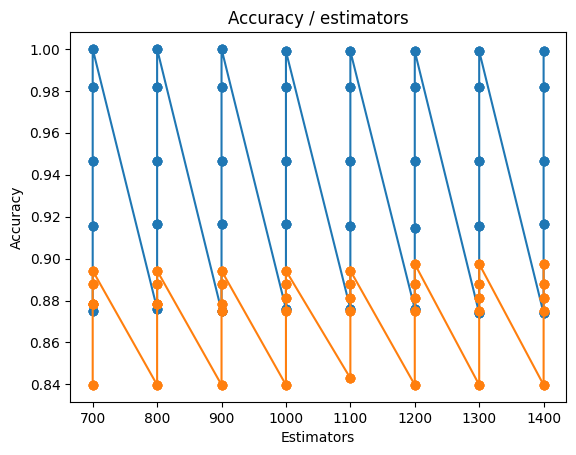

In [63]:
plot_data = pd.read_csv('random_forest.csv', header=0)
plot_df = pd.DataFrame(plot_data)


plt.plot(plot_df['Estimators'], plot_df['Accuracy Train'], marker='o')
plt.plot(plot_df['Estimators'], plot_df['Accuracy Test'], marker='o')
plt.xlabel('Estimators')
plt.ylabel('Accuracy')
plt.title('Accuracy / estimators')
plt.show()


In [232]:
# Testing feature selection on the best performing RandomForest:

sfs = SequentialFeatureSelector(knn, n_features_to_select=5, direction="forward", n_jobs=4)
sfs = sfs.fit(X_train, y_train)

rf2 = RandomForestClassifier(n_estimators=1800, random_state=42, n_jobs=4, max_depth=15, criterion='gini')

X_train_sfs = sfs.transform(X_train)
X_test_sfs = sfs.transform(X_test)
# X_eval_sfs = sfs.transform(X_eval)

rf2.fit(X_train_sfs, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_pred, y_test)
accuracy

# It didn't work out well

0.8974358974358975

### Kaggle submission

In [20]:
"""The .csv-list over random forest performances indicated that 1200-1400 estimators, 3 jobs and max depth 10 would do.
I then made this code to create .csv-lists of predictions for different random forests with nearby hyperparameters. Surprisingly,
the first one I uploaded - 1200 estimators, 3 jobs, 10 max depth - still holds the record amongst my submissions with .91452, although I did upload
several models with the parameters tweaked a bit to check for wiggle room."""

rf_final = RandomForestClassifier(n_estimators=1200, random_state=42, n_jobs=10, max_depth=200)

rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_eval)

rf_df = pd.DataFrame(y_pred, columns=['Edible'])
rf_df.to_csv(f'RandomForest_1200_3_10.csv', index_label='index')